# Imports

In [1]:
import sys
import os
import time
import cPickle
sys.path.append('./models/slim')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.transform import resize
from sklearn.decomposition import PCA
import tqdm

from preprocessing import inception_preprocessing 
from nets.inception_v4 import inception_v4_arg_scope, inception_v4

from nmslib_util import create_index, query_index

# Folder locations

In [2]:
model_checkpoint_path = '/home/user/FER/AVSP/inception_v4.ckpt'
root_image_folder = '/home/user/Open_image/images_2016_08/train/images'
raw_result_folder = '/home/user/FER/AVSP/raw_results'
temp_vector_result_folder = '/home/user/FER/AVSP/temp_results'
final_result_folder = '/home/user/FER/AVSP/final_results'

# Utils

In [50]:
def get_img(path):
    img = io.imread(path)
    img = resize(img,(229,229))
    return img

def show_img(path):
    plt.figure(figsize=(16,12))
    img = get_img(path)
    plt.imshow(img)
    plt.show()
    
def maxpool2d(x, k=2, stride=2, padding='SAME'):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, stride, stride, 1],
                          padding=padding)


def find_similar(test_path, index, paths, top_n_results = 12, cosine=True, verbose = False, PCA_model=None):    
    test_img = io.imread(test_path)   
    
    test_img = resize(test_img,(229,229), mode = 'constant')
    
    test = sess.run(preprocessed_img, feed_dict={placeholder_input:test_img})
    test_vec = sess.run(pred,feed_dict={images:[test]})[0].flatten()
    if PCA_model:
        test_vec = PCA_model.transform([test_vec])[0]
    
    similar_images = query_index(index, np.array([test_vec, test_vec]), top_n_results, True) [0]
    #Query data is stacked because without it i get "the order of matrix should be C not FORTRAN" error when i query with
    #a single vector and didnt manage to resolve it otherwise :(

    print
    test_img = io.imread(test_path)
    plt.figure(figsize=(16,12))
    plt.imshow(test_img)
    plt.title("Query image - %s" % test_path)
    plt.show()
    
    img_cnt=0
    fig, ax = plt.subplots(int(np.ceil(top_n_results/3.)),3,figsize=(16,12))
    ax = np.array(ax).flatten()
    
    for ind in similar_images:
        img = io.imread(paths[ind])
        ax[img_cnt].imshow(img)
        img_cnt+=1
        
    fig.tight_layout()
    plt.show()


# This creates a concatenated vector with the result of max pooling all the endpoints with maximum size kernel for them
# for example an output of convolution is 12x12x1024, then max pool will be with kernel [1,12,12,1] and padding VALID
# the resulting vector will be 1,1,1024 for each image
def create_prediction(endpoints):
    values_to_concat = []
    for end in sorted(endpoints):
        if 'Pred' in end or 'Log' in end: 
            continue
        all_channels_maxpool = maxpool2d(end_points[end],end_points[end].shape[1], padding = 'VALID')
        values_to_concat.append(all_channels_maxpool)
    concatenated = tf.concat(values_to_concat,3)
    return concatenated

# Inception initialization and restoration

In [4]:
slim = tf.contrib.slim
images = tf.placeholder(tf.float32, [None, 229,229,3])

with slim.arg_scope(inception_v4_arg_scope()):
    logits, end_points = inception_v4(images, num_classes = 1001, is_training = False)
    
exclude = ['InceptionV4/Logits', 'InceptionV4/AuxLogits']
exclude = ['InceptionV4/AuxLogits']
variables_to_restore = slim.get_variables_to_restore(exclude = exclude)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(variables_to_restore)
saver.restore(sess, model_checkpoint_path)

# Creating the prediction endpoint by maxpooling all the layers
pred = create_prediction(end_points)

#inputs for preprocessing
placeholder_input = tf.placeholder(tf.float32, [None,None,None])
preprocessed_img = inception_preprocessing.preprocess_image(placeholder_input, 229, 229, False)

# Loading PCA and numpy arrays

In [5]:
PCA_model = PCA(n_components=300)
PCA_location = os.path.join(final_result_folder,'PCA_model_300.pkl')

with open(PCA_location, 'rb') as f:
    PCA_model = cPickle.load(f)
    
vector_path = os.path.join(final_result_folder,'full_vectors.npy')
vectors = np.load(vector_path)

paths_path = os.path.join(final_result_folder,'full_paths.npy')
paths = np.load(paths_path)

# Build index from vectors

In [47]:
var = vectors.shape[0]
for i in range(1,var):
    if var % i == 0:
        print "batch size candidate = %d" % i

batch size candidate = 1
batch size candidate = 3
batch size candidate = 7
batch size candidate = 21
batch size candidate = 29
batch size candidate = 87
batch size candidate = 203
batch size candidate = 609
batch size candidate = 1499
batch size candidate = 4497
batch size candidate = 10493
batch size candidate = 31479
batch size candidate = 43471
batch size candidate = 130413
batch size candidate = 304297


In [48]:
index = create_index(vectors, batch_size = 609, convert = True)

cosinesimil
['knn=1']
vptree


In [49]:
#index.clr_mem()

# Querying

Query 0



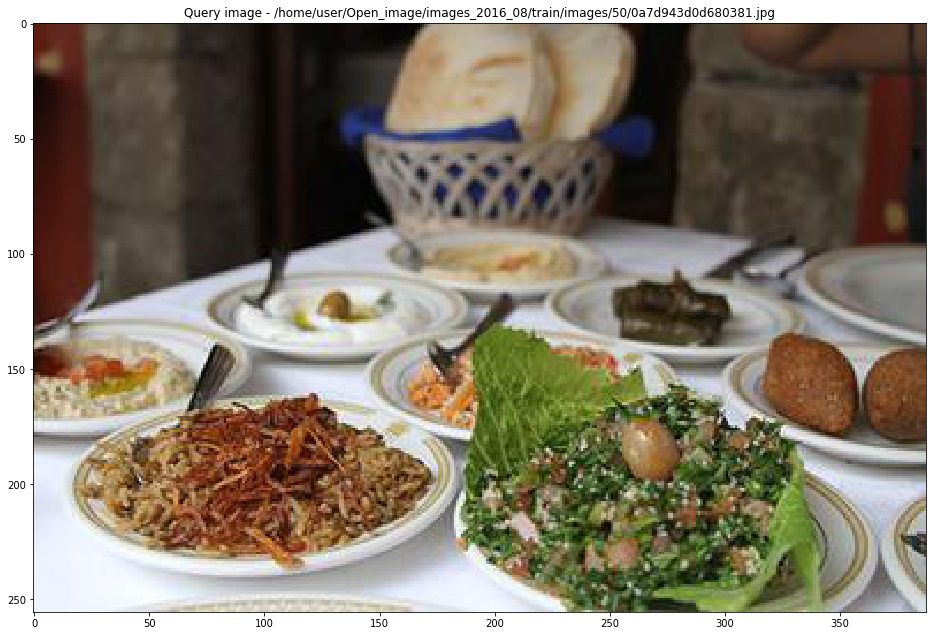

In [ ]:
Image_test_paths = ['/home/user/Open_image/images_2016_08/train/images/50/0a7d943d0d680381.jpg',
                '/home/user/Open_image/images_2016_08/train/images/0/02c918a44db6d58b.jpg',
                '/home/user/Open_image/images_2016_08/train/images/0/002dbd19df89cddc.jpg',
                '/home/user/Open_image/images_2016_08/train/images/0/017d94a263e9c3de.jpg',
                '/home/user/Open_image/images_2016_08/train/images/0/009a7c214f652500.jpg',
                '/home/user/Open_image/images_2016_08/train/images/0/0337edae58c79981.jpg',
                '/home/user/Open_image/images_2016_08/train/images/10/00e6c344e0835bee.jpg',
                '/home/user/Open_image/images_2016_08/train/images/10/03a948040a01bfa6.jpg',
                '/home/user/Open_image/images_2016_08/train/images/10/039d0d1924881362.jpg']

for i,path in enumerate(Image_test_paths):
    print "Query %d" % i
    find_similar(path, index = index, paths = paths, top_n_results = 12, cosine=True, PCA_model=PCA_model)
    print "\n\n\n\n\n\n"
    time.sleep(2) #notebook data rate exceeded when it outputs too fast thats why there is a sleep here
    